In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 781.1 kB/s eta 0:00:0000:0100:10
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 981.7 kB/s eta 0:00:00a 0:00:01
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425364 sha256=c2de7a1e40c89b2a20bea54d1cded795042cc635836b18767a0e8d117667e436
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Part 1

In [1]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


In [3]:
conf = SparkConf().set("spark.executor.instances", "2").set("spark.executor.cores", "1").set("spark.executor.memory", "1g")

In [4]:
sc = SparkContext(appName="Kasyanov_spark", master="yarn")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/26 16:22:54 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


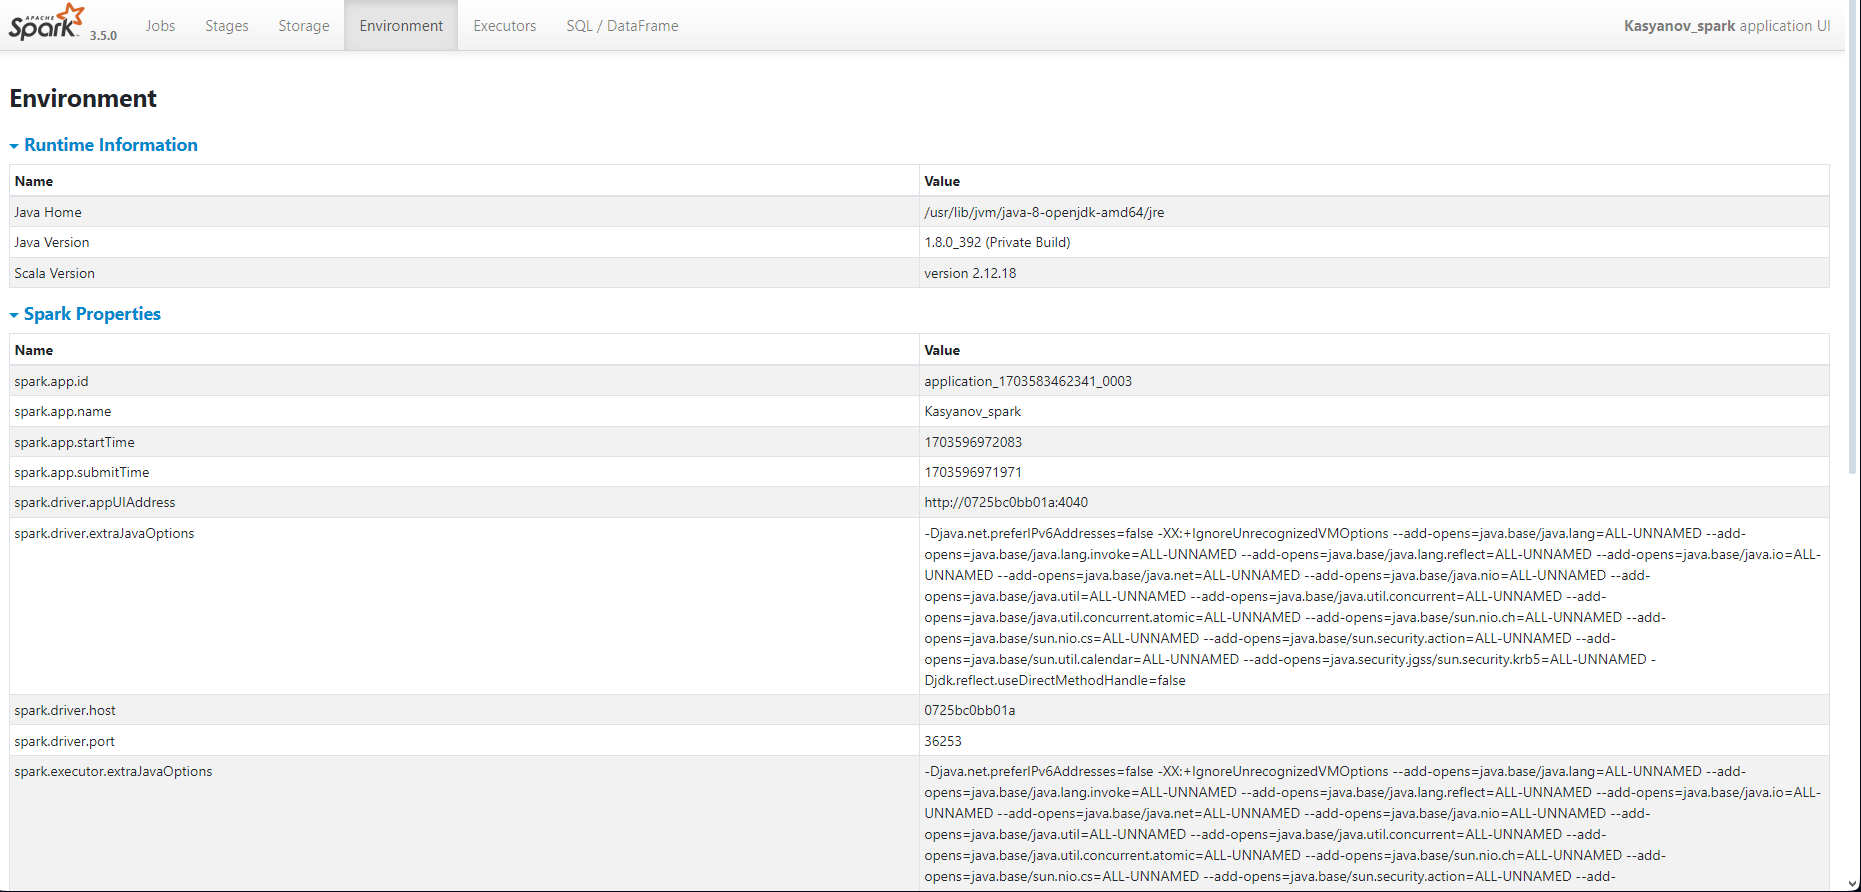

In [5]:
spark = SparkSession.builder \
    .appName("Kasyanov_spark") \
    .master("yarn") \
    .config("spark.executor.instances", "2") \
    .getOrCreate()

In [6]:
!hdfs dfs -put ml-latest-small .

put: `ml-latest-small/movies.csv': File exists
put: `ml-latest-small/ratings.csv': File exists
put: `ml-latest-small/README.txt': File exists
put: `ml-latest-small/links.csv': File exists
put: `ml-latest-small/tags.csv': File exists


In [9]:
ratings = spark.read.format('csv').option('header','true').load('ml-latest-small/ratings.csv')
tags = spark.read.format('csv').option('header','true').load('ml-latest-small/tags.csv')
print(f"Number of rows in 'ratings': {ratings.count()}")
print(f"Number of rows in 'tags': {tags.count()}")

Number of rows in 'ratings': 100836
Number of rows in 'tags': 3683


completed stages — 10
succeeded tasks — 10

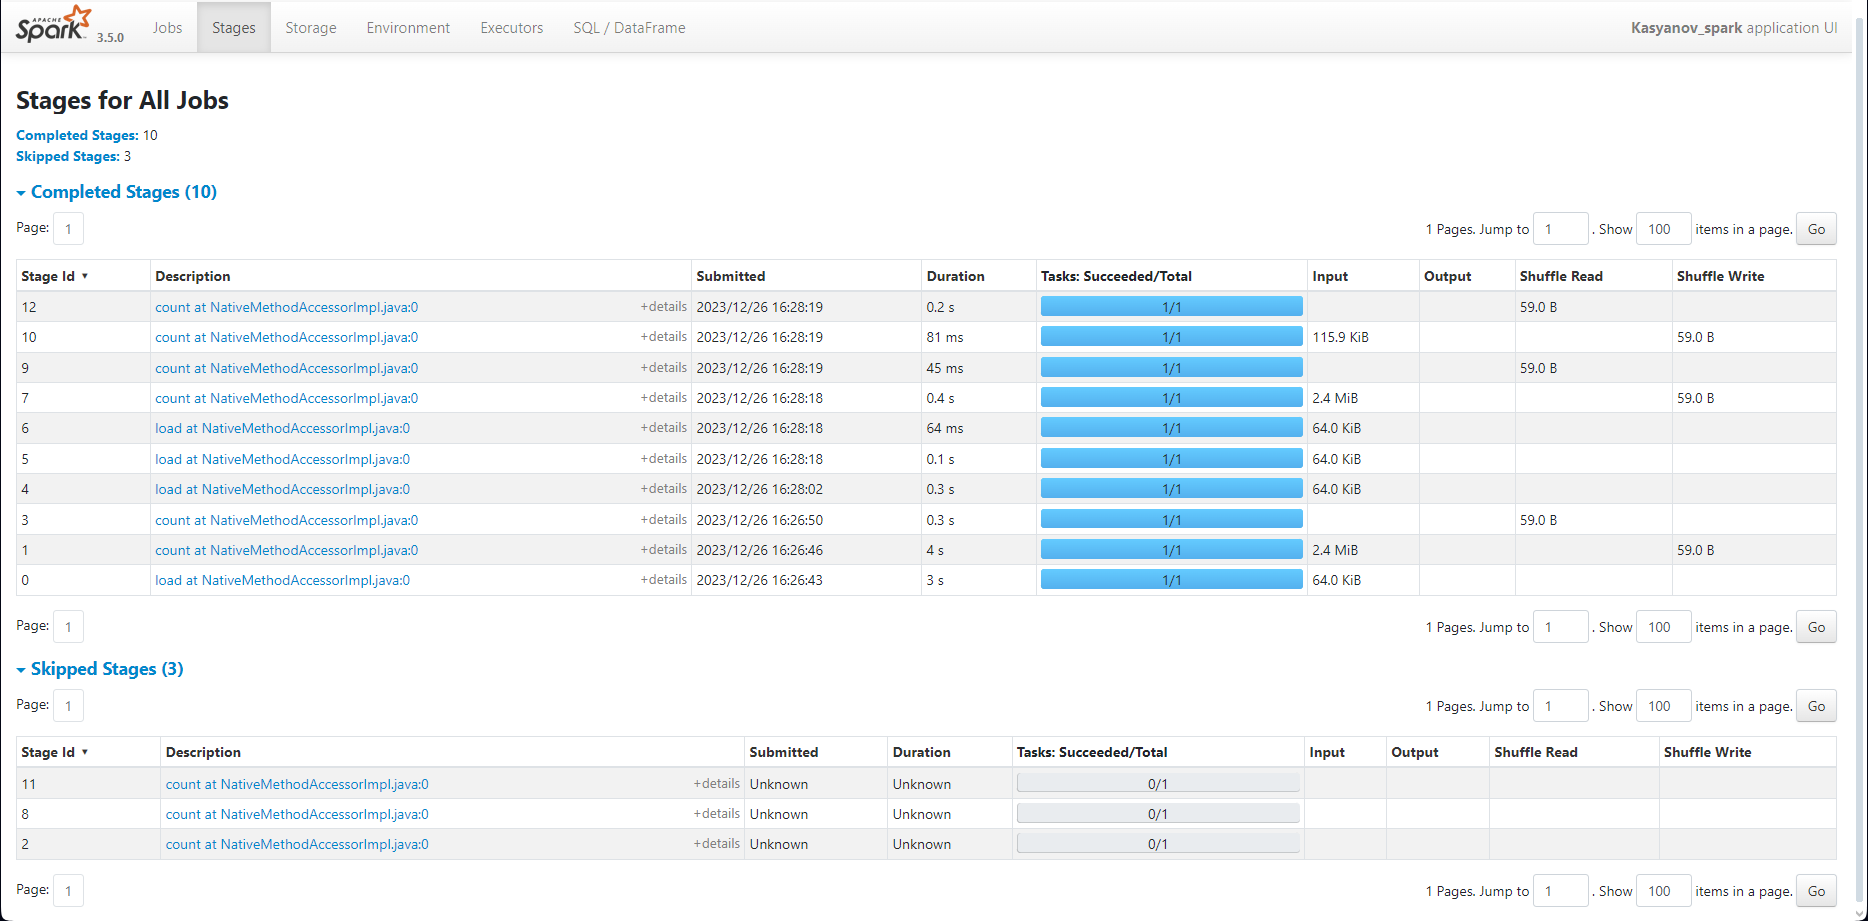

In [10]:
spark

# Part 2

In [33]:
from pyspark.sql.functions import col, abs
from pyspark.sql.functions import countDistinct

In [34]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_ratings: long (nullable = true)



In [35]:
tags.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_tags: long (nullable = true)



In [36]:
ratings = ratings.withColumn("rating", col("rating").cast("float"))

 ### Kоличество уникальных фильмов и уникальных юзеров в таблице “ratings

In [37]:
unique_movies = ratings.agg(countDistinct("movieId").alias("unique_movies"))
unique_users = ratings.agg(countDistinct("userId").alias("unique_users"))

unique_movies.show()
unique_users.show()

+-------------+
|unique_movies|
+-------------+
|         9724|
+-------------+

+------------+
|unique_users|
+------------+
|         610|
+------------+



### Cколько было поставлено оценок >= 4.0

In [38]:
high_ratings = ratings.filter(ratings["rating"] >= 4.0).count()
print(f"Number of ratings >= 4.0: {high_ratings}")

Number of ratings >= 4.0: 48580


### Tоп100 фильмов с самым высоким рейтингом

In [39]:
top100_movies = ratings.groupBy("movieId").mean("rating").orderBy("avg(rating)", ascending=False).limit(100)
top100_movies.show()

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
|   5059|        5.0|
|  76091|        5.0|
|    495|        5.0|
| 139640|        5.0|
| 102217|        5.0|
|    467|        5.0|
| 149350|        5.0|
|  69469|        5.0|
| 147330|        5.0|
| 136447|        5.0|
|   1349|        5.0|
| 151769|        5.0|
|  67618|        5.0|
| 179135|        5.0|
| 136355|        5.0|
|   5745|        5.0|
| 149508|        5.0|
|   4402|        5.0|
| 160644|        5.0|
|  73822|        5.0|
+-------+-----------+
only showing top 20 rows



### Pазницa во времени в секундах между временем тегирования пользователя данного фильма и временем, когда пользователь поставил оценку фильму

In [40]:
ratings = ratings.withColumn("timestamp_ratings", col("timestamp").cast("long"))
tags = tags.withColumn("timestamp_tags", col("timestamp").cast("long"))

tags_ratings = tags.join(ratings, on=["userId", "movieId"], how="inner")

time_diff = tags_ratings.withColumn("time_diff", abs(col("timestamp_tags") - col("timestamp_ratings")))
avg_time_diff = time_diff.groupBy().avg("time_diff")

avg_time_diff.show()

+--------------------+
|      avg(time_diff)|
+--------------------+
|2.9203715568469506E7|
+--------------------+



### Cредняя оценка от каждого пользователя

In [41]:
user_avg_ratings = ratings.groupBy("userId").avg("rating")
overall_avg_rating = user_avg_ratings.groupBy().avg("avg(rating)")
overall_avg_rating.show()

+------------------+
|  avg(avg(rating))|
+------------------+
|3.6572223377474007|
+------------------+



# Part 3

In [44]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 832.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 818.9 kB/s eta 0:00:0000:0100:02


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor
import pandas as pd

# Convert Spark DataFrame to Pandas
ratings_pd = ratings.toPandas()
tags_pd = tags.toPandas()

# Merge ratings and tags DataFrames
data_pd = pd.merge(ratings_pd, tags_pd, on=["userId", "movieId"])

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'tag' column
X = vectorizer.fit_transform(data_pd['tag'])

# Convert 'rating' column to float and fit the model
y = data_pd['rating'].astype(float)
model = SGDRegressor()
model.fit(X, y)

SGDRegressor()

In [46]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Define the UDF
def predict_rating(tag):
    # Transform the tag using the vectorizer and predict the rating
    tag_vector = vectorizer.transform([tag])
    return float(model.predict(tag_vector)[0])

# Register the UDF
predict_rating_udf = udf(predict_rating, FloatType())

In [49]:
# Apply the UDF to the 'tag' column
df_with_predictions = tags.withColumn("predicted_rating", predict_rating_udf(tags['tag']))

# Show the DataFrame
df_with_predictions

DataFrame[userId: string, movieId: string, tag: string, timestamp: bigint, timestamp_tags: bigint, predicted_rating: float]